# Table of Contents
1. [Importing Libraries](#importing-libraries)
2. [Data Description](#data-description)
    * [Multiple Genres](#multiple-genres)
    * [Visualisation](#visualisation)
3. [Data Preprocessing](#data-cleaning)
4. [Data Modelling](#data-modelling)
    * [Neural Network](#neural-network)
    * [K-Nearest Neighbours](#k-nearest-neighbours)
    * [Random Forest](#random-forest)
    * [Model Comparison](#model-comparison)

## Importing Libraries <a class="anchor" id="importing-libraries"></a>

Here, we import all the necessary libraries for our work.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt

from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras import layers, metrics

## Data Description <a class="anchor" id="data-description"></a>

First, the data is loaded and basic information about the data is displayed.

In [57]:
tracks = pd.read_csv('csvs/dataset.csv', index_col=0)

tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Our goal is to identify and predict the genres of the song, so we try display and see how many genres are there in the dataset.

In [58]:
print('Number of genres: {}'.format(tracks.track_genre.nunique()))

# Get a count of all genre
tracks.track_genre.value_counts()

Number of genres: 114


track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64

### Multiple Genres <a class="anchor" id="multiple-genres"></a>
 
We discover that some song may have multiple genres. To improve our modelling, we will be using tracks with one genre only. 

In [59]:
# Sort by popularity first, so when we drop duplicate we drop lower popularity
# Drop duplicate if track_name, duration_ms, artists and track_genre are all the same
tracks.sort_values(by=['popularity'],ascending=False,inplace=True)
tracks.drop_duplicates(subset=['track_name','duration_ms','artists','track_genre'],inplace=True)

# If track_name, duration_ms and artists are same, but genre is different, aggregate the genre
tracks = tracks.groupby(['track_name','duration_ms','artists'],as_index=False).agg({'track_genre':lambda x: ','.join(x),
                                                                                                  'album_name': 'first',
                                                                                                  'track_id': 'first',
                                                                                                  'popularity': 'max',
                                                                                                  'explicit': 'first',
                                                                                                  'danceability': 'first',
                                                                                                  'energy': 'first',
                                                                                                  'loudness': 'first',
                                                                                                  'speechiness': 'first',
                                                                                                  'acousticness': 'first',
                                                                                                  'instrumentalness': 'first',
                                                                                                  'liveness': 'first',
                                                                                                  'valence': 'first',
                                                                                                  'tempo': 'first',
                                                                                                  'key': 'first',
                                                                                                  'mode': 'first',
                                                                                                  'time_signature': 'first'})


# Remove all tracks with more than one genre
tracks = tracks[tracks['track_genre'].str.contains(',') == False]
tracks.track_genre.value_counts()

track_genre
study          996
tango          991
comedy         987
grindcore      984
honky-tonk     974
              ... 
house          118
indie           94
alternative     87
reggae          78
reggaeton       66
Name: count, Length: 112, dtype: int64

Additionally, any genre with less than 500 tracks does not constitute enough training and test sample, and will be removed from the dataset.

In [60]:
# Remove all genres with less than 500 tracks, maintain all columns
tracks = tracks.groupby('track_genre').filter(lambda x: len(x) > 500)
tracks.track_genre.value_counts()

track_genre
study         996
tango         991
comedy        987
grindcore     984
honky-tonk    974
             ... 
emo           533
german        532
country       522
psych-rock    521
groove        510
Name: count, Length: 78, dtype: int64

To make our modelling easier, we will limit our selection to a hand selected few genres. As much as the top 10 genre present an interesting opportunity, a cursory glance at the data shows that the top 10 genres are not very distinct from each other. Hence, we will select a few genres that are more significantly distinct from one another.

In [61]:
genre_popularity = tracks.groupby('track_genre')['popularity'].mean()
genre_popularity.sort_values(ascending=False)

# What is the difference between pop-film, k-pop, pop? 
# And what is the difference between sad and emo?

track_genre
k-pop             59.071334
pop-film          56.744038
chill             56.228319
sad               52.147114
piano             50.342262
                    ...    
grindcore         14.520325
chicago-house     12.174381
detroit-techno    11.007487
romance            3.562077
iranian            2.245868
Name: popularity, Length: 78, dtype: float64

We choose the following genre for our modelling, and remove the rest of the genres from the dataset.
- Country
- Chill
- K-Pop
- Club
- Rock-n-Roll
- Classical
- Sleep
- Electronic
- Ambient
- Opera

In [62]:
# Retain only the genres listed above
tracks = tracks[tracks['track_genre'].isin(['country', 'chill', 'k-pop', 'club', 'rock-n-roll', 'classical', 'sleep', 'electronic', 'ambient', 'opera'])]

### Visualisation <a class="anchor" id="visualisation"></a>

Since we have our genres sorted, we can now visualise the data to see if there are any interesting patterns.

In [63]:
# Filter out all features that are not numerical
feature_numerical = [feature for feature in tracks.columns if tracks[feature].dtype!='O']

# If a feature has less than 50 unique values, it is considered as discrete
discrete_features = [feature for feature in feature_numerical if tracks[feature].nunique()<50]
continuous_features = [feature for feature in feature_numerical if feature not in discrete_features]

We first plot grouped barcharts to see the incidence of each discrete numerical feature corresponding to each genre.

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


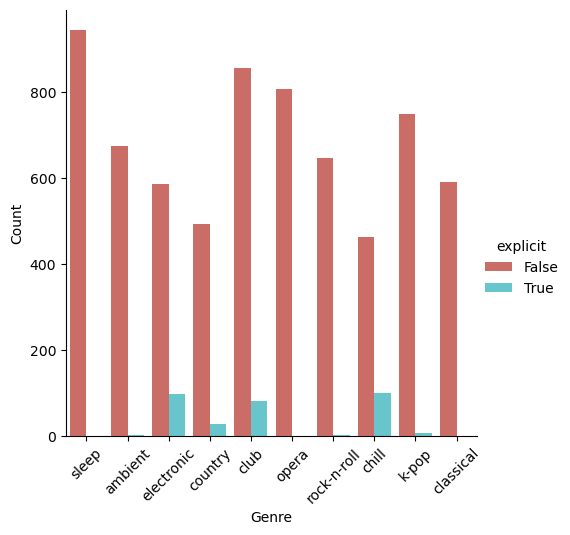

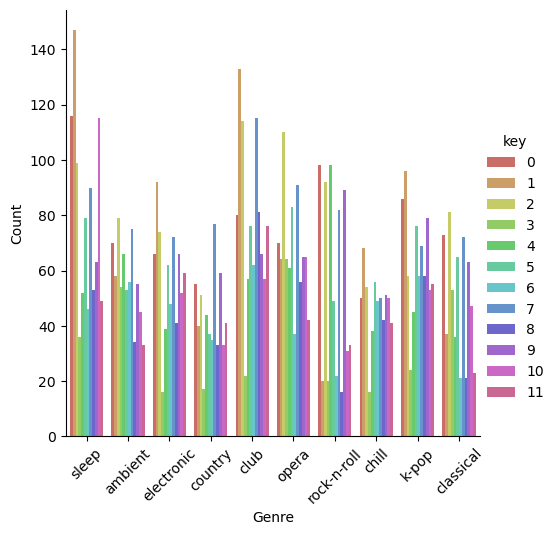

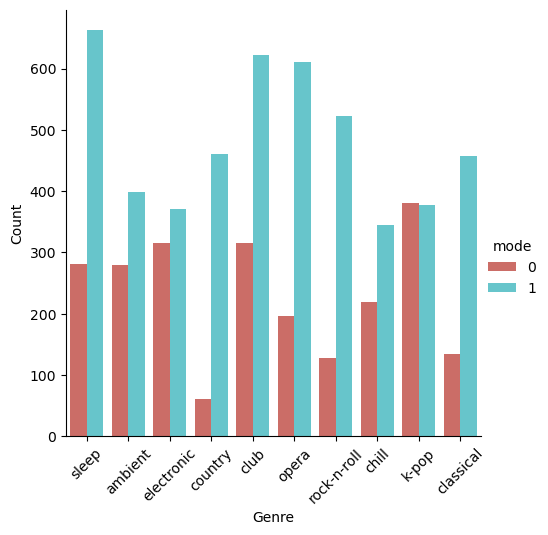

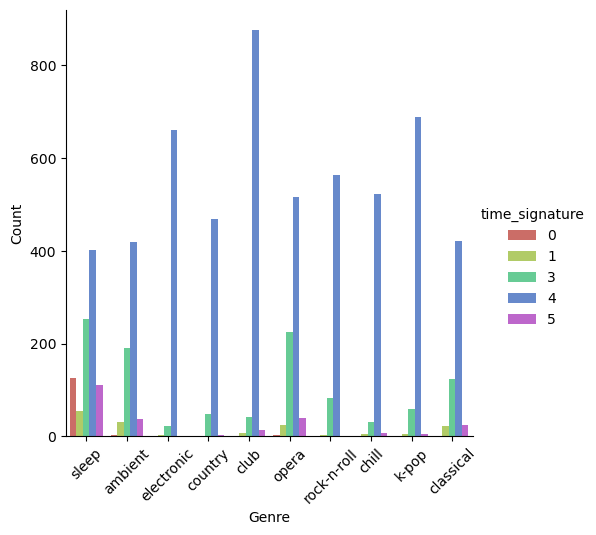

In [64]:
for feature in discrete_features:
    g = sns.catplot(
        data=tracks, kind="count",
        x="track_genre", hue=feature,
        estimator=np.median, palette="hls"
    )

    g.set_axis_labels("Genre", "Count")
    g.set_xticklabels(rotation=45)
    g.legend.set_title(feature)

Then we plot grouped boxenplots to see the distribution of each continuous numerical feature corresponding to each genre. This helps us to identify outliers and the statistical distribution of each feature.

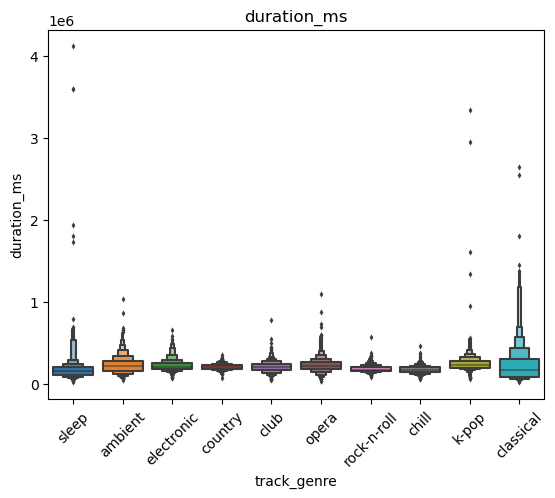

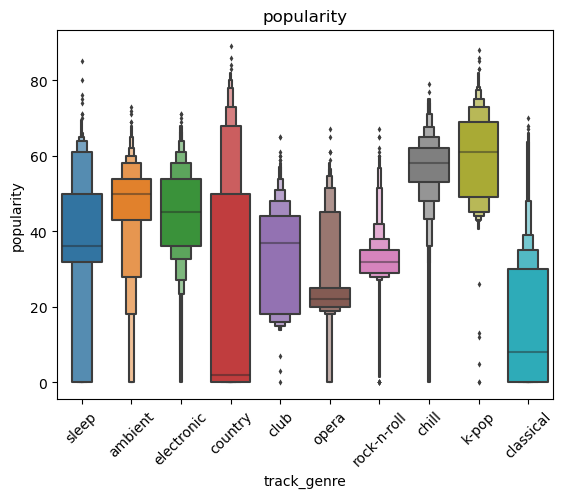

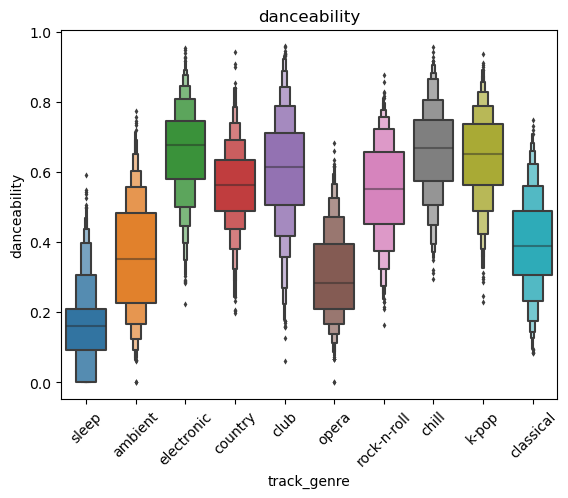

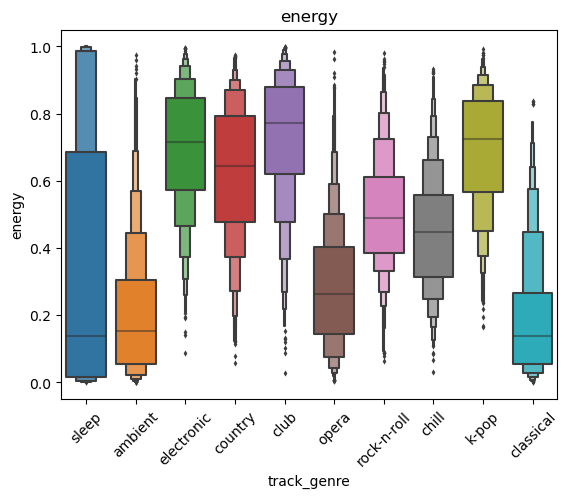

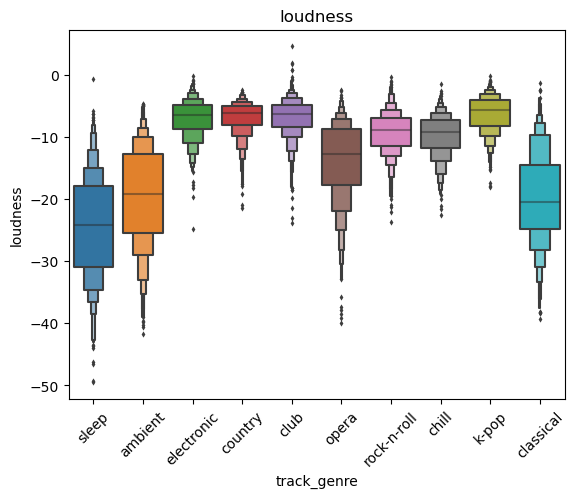

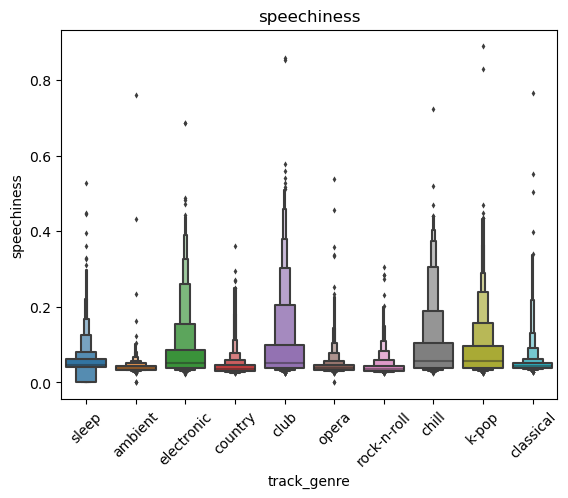

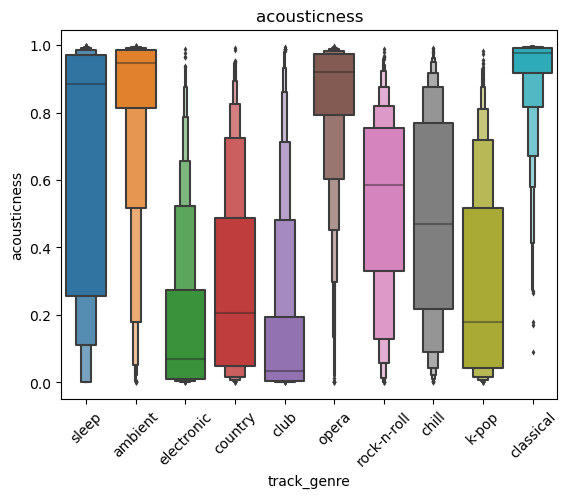

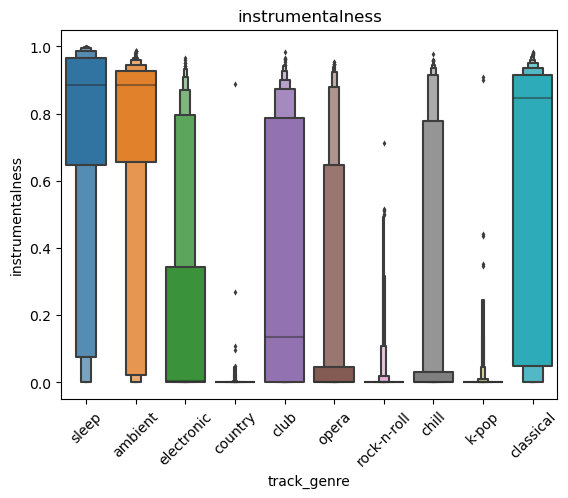

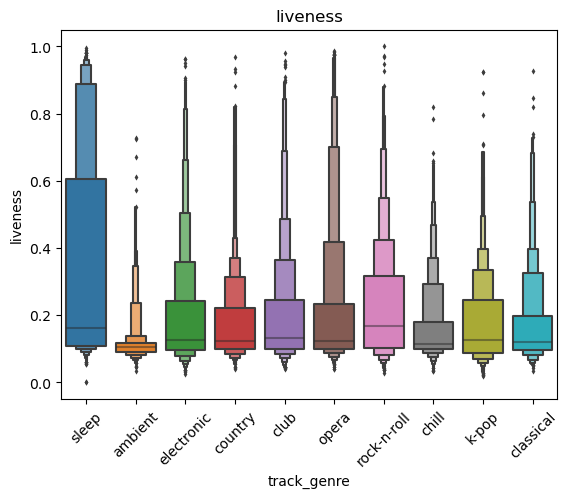

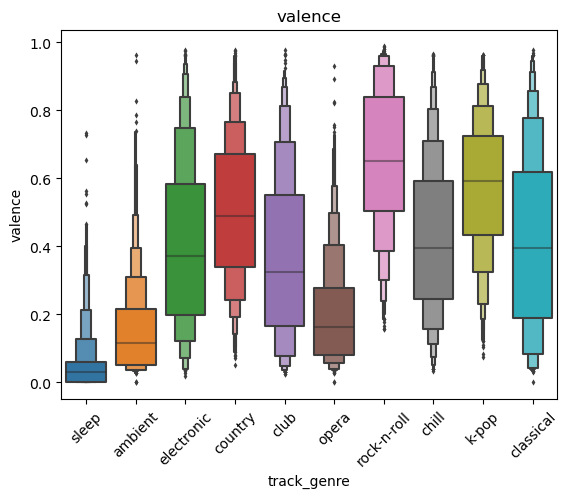

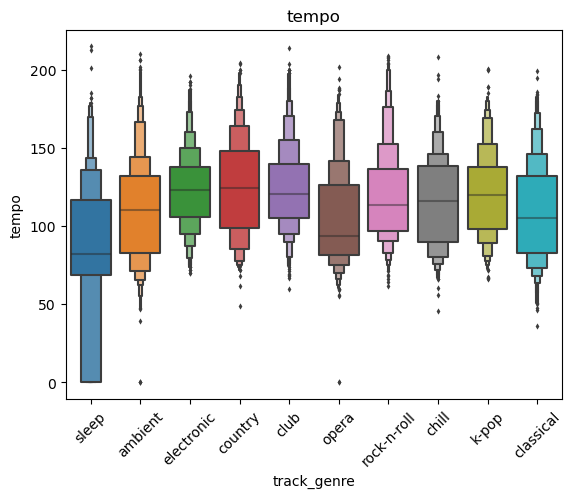

In [65]:
for feature in continuous_features:
    g = sns.boxenplot(
        data=tracks, x="track_genre", y=feature,
        flier_kws=dict(linewidths=0, s=10)
    )

    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set(title=feature)
    plt.show()

We're also checking the density of each continuous numerical feature corresponding to each genre. This helps us visualise which genre dominates which range of values for each feature.

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


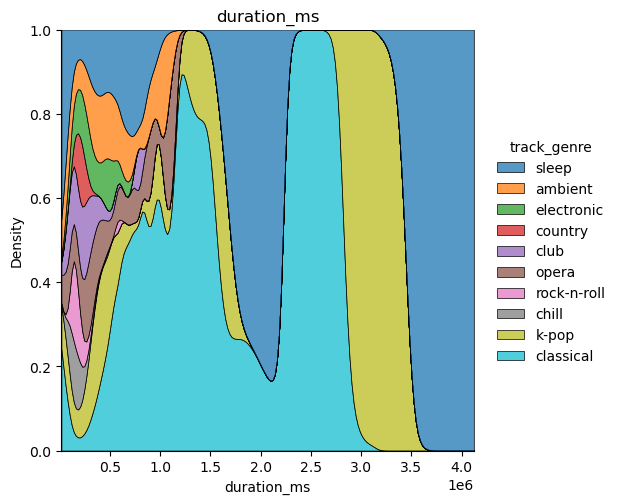

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


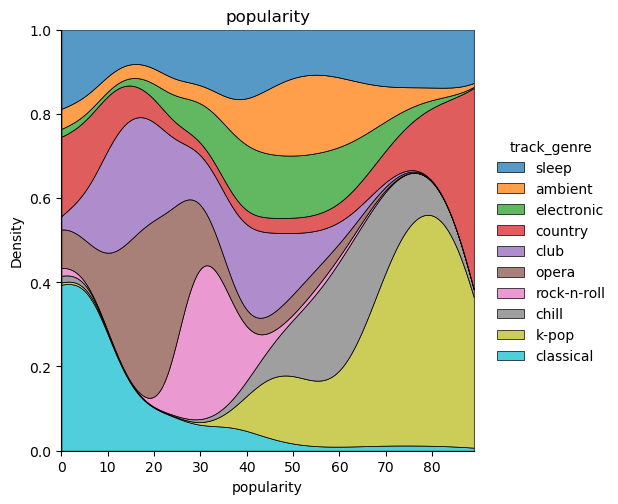

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


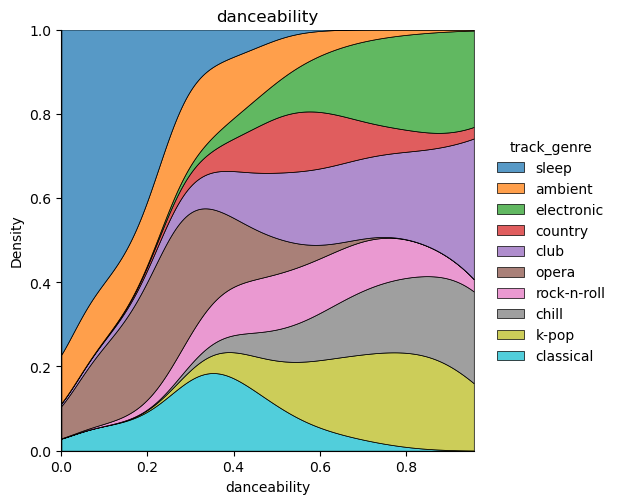

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


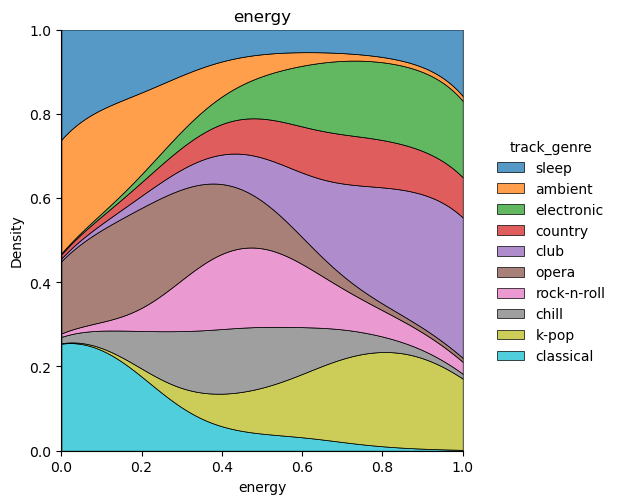

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


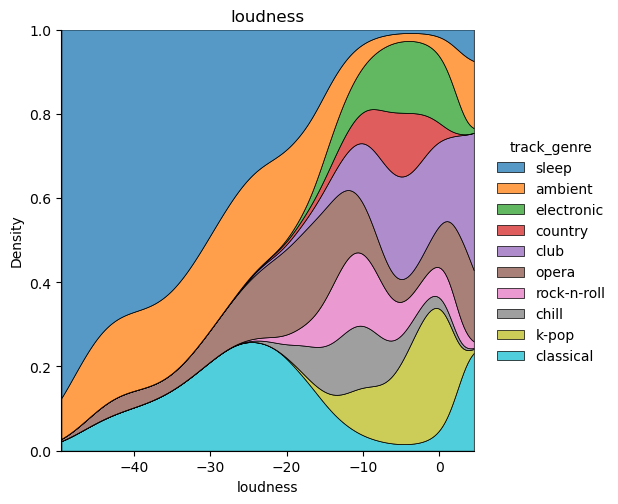

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


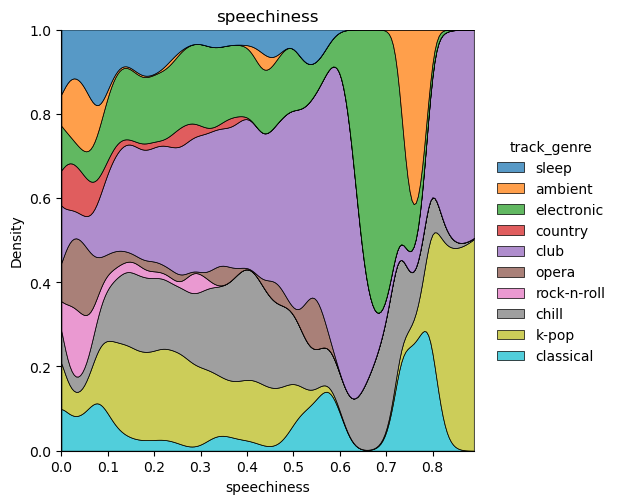

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


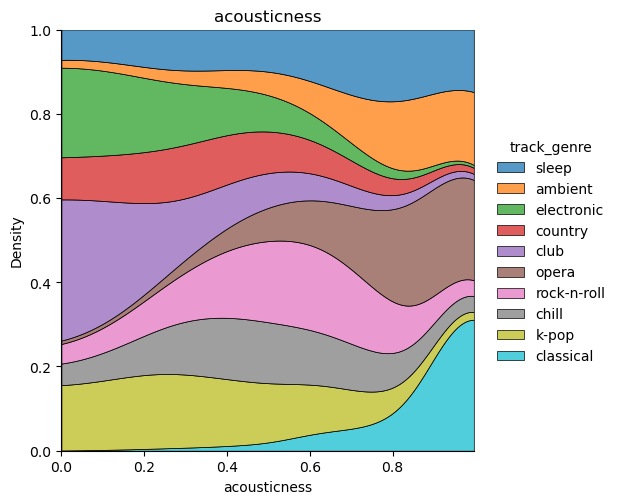

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


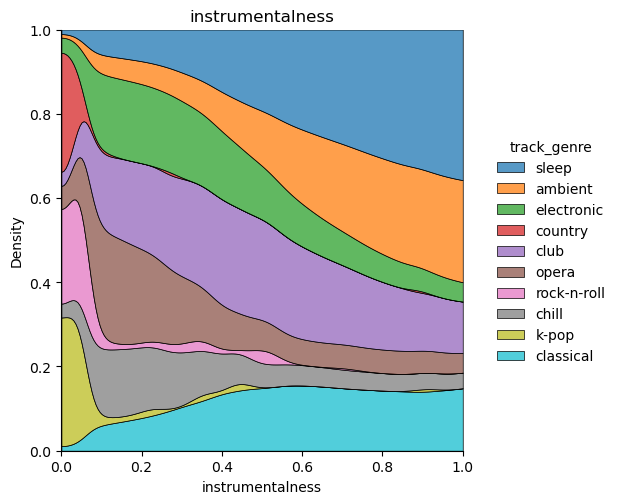

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


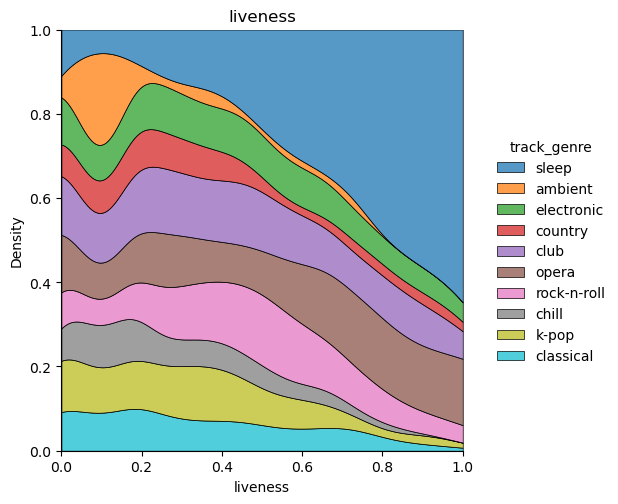

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


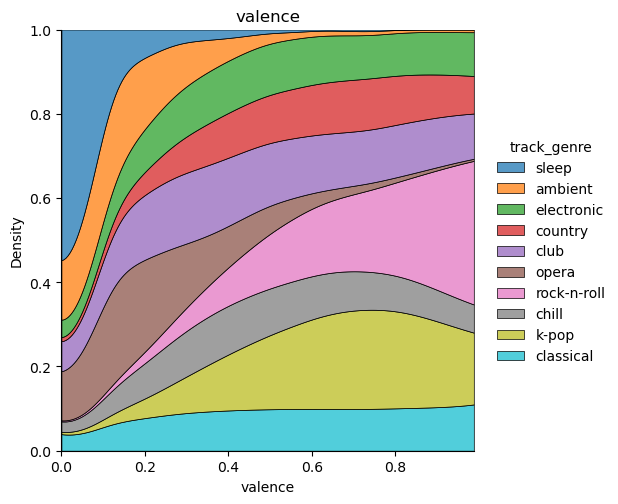

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


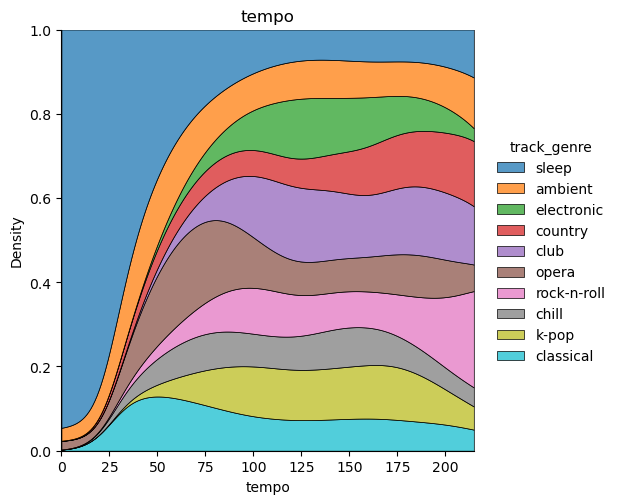

In [66]:
for feature in continuous_features:
    g = sns.displot(
        data=tracks, x=feature, hue="track_genre", 
        multiple="fill", kind="kde", bw_adjust=2,
        linewidth=0.5, clip=(tracks[feature].min(), tracks[feature].max())
    )

    g.set(title=feature)
    plt.show()

We check the histogram density of each discrete numerical feature to see if there are any interesting patterns.

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\_stats\counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


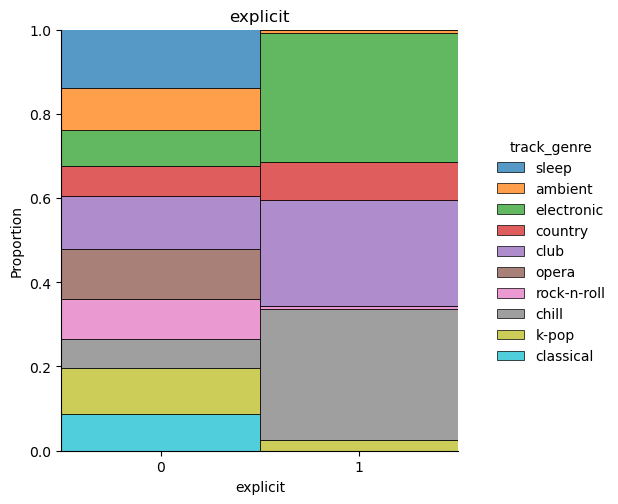

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


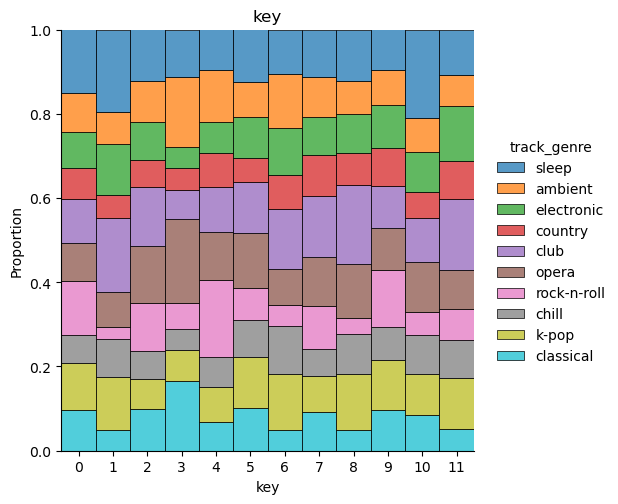

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


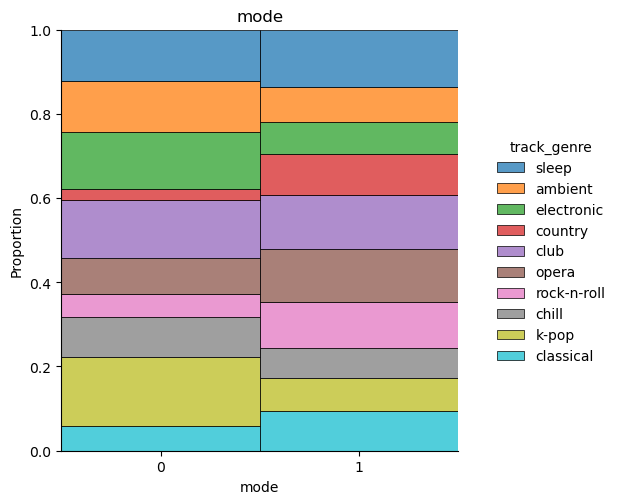

c:\Users\KohCo\miniconda3\envs\data-mining\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


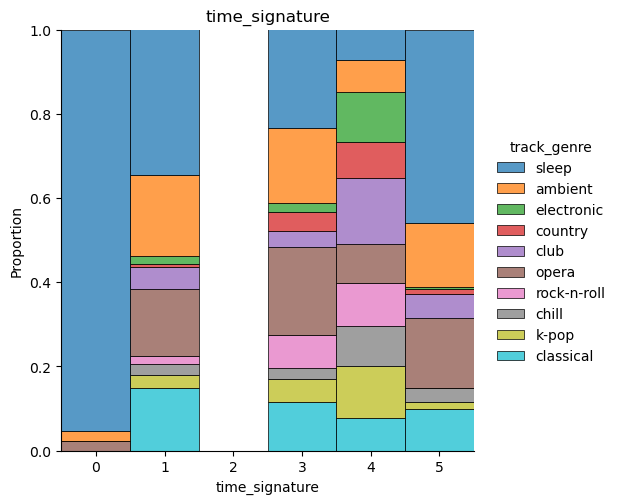

In [67]:
for feature in discrete_features:
    g = sns.displot(
        data=tracks, x=feature, hue="track_genre", 
        linewidth=0.5, multiple="fill",
        discrete=True
    )

    g.set(title=feature, ylabel="Proportion", \
        xticks=range(0, tracks[feature].max() + 1))
    plt.show()

## Data Preprocessing <a class="anchor" id="data-cleaning"></a>

We start off with basic data cleaning, removing null data and removing unnecessary columns according to our EDA.

In [68]:
# Drop the row where track_name = null
tracks.drop(tracks.index[tracks['track_name'].isnull()], inplace=True)

We will also remove Track ID from our dataset as the ID is randomly generated data. Additionally, track name, artist name and album name will be removed as well. These three category are too diverse and will be hard to generalize, even if they provide very useful information. 

We will also drop the track key, as it will present too many dimension for our model to handle.

In [69]:
# Drop the track_id column
tracks.drop('track_id', axis=1, inplace=True)

# Drop the track_name, artists, album_name columns
tracks.drop(['track_name', 'artists', 'album_name'], axis=1, inplace=True)

# Drop the key column
tracks.drop('key', axis=1, inplace=True)

Next, we will discretize both loudness, tempo and duration_ms into 10 bins each. The exact value of these columns are not important, but their rough bins will help better inform the model.

We will also normalise the popularity columns, as they are on a different scale from the rest of the data.

In [70]:
# Discretize the loudness column into 10 bins, normalised within 0 and 1
tracks['loudness'] = pd.cut(tracks['loudness'], 10, labels=False)
tracks['loudness'] = MinMaxScaler().fit_transform(tracks[['loudness']])

# Discretize the tempo column into 10 bins, normalised within 0 and 1
tracks['tempo'] = pd.cut(tracks['tempo'], 10, labels=False)
tracks['tempo'] = MinMaxScaler().fit_transform(tracks[['tempo']])

# Normalise the duration_ms column through the use of log transformation, then normalise within 0 and 1
tracks['duration_ms'] = np.log(tracks['duration_ms'])
tracks['duration_ms'] = MinMaxScaler().fit_transform(tracks[['duration_ms']])

# Normalise the popularity column through MinMaxScaler
tracks['popularity'] = MinMaxScaler().fit_transform(tracks[['popularity']])

# Normalise the time_signature column through MinMaxScaler
tracks['time_signature'] = MinMaxScaler().fit_transform(tracks[['time_signature']])

# Describe the dataset
tracks.describe()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode,time_signature
count,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000,7143.000000
mean,0.438320,0.421650,0.477782,0.477257,0.701837,0.065801,0.515192,0.308702,0.209258,0.359005,0.525378,0.676046,0.748789
std,0.081620,0.224826,0.219627,0.297521,0.180076,0.071441,0.381924,0.401518,0.195412,0.274434,0.174052,0.468015,0.156349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.402446,0.269663,0.302000,0.220000,0.555556,0.034650,0.105500,0.000001,0.098400,0.108500,0.444444,0.000000,0.800000
50%,0.443685,0.438202,0.504000,0.481000,0.777778,0.043300,0.557000,0.003090,0.123000,0.312000,0.555556,1.000000,0.800000
75%,0.480905,0.595506,0.650000,0.734000,0.777778,0.062300,0.914000,0.813000,0.248000,0.573500,0.666667,1.000000,0.800000
max,1.000000,1.000000,0.958000,1.000000,1.000000,0.889000,0.996000,1.000000,1.000000,0.988000,1.000000,1.000000,1.000000


Next, we make sure each of the genres has 500 sample exactly.

In [71]:
# Drop individual rows until the number of tracks per genre is equal
tracks = tracks.groupby('track_genre').apply(lambda x: x.sample(tracks.track_genre.value_counts().min(), random_state=42).reset_index(drop=True))
tracks.track_genre.value_counts()

track_genre
ambient        522
chill          522
classical      522
club           522
country        522
electronic     522
k-pop          522
opera          522
rock-n-roll    522
sleep          522
Name: count, dtype: int64

Then, we output the data into a csv file for possible reference.

In [72]:
tracks.to_csv('csvs/clean_data.csv',index=False)

## Data Modelling <a class="anchor" id="data-modelling"></a>

We split the data into training and test set, with 80% of the data going into training and 20% going into test.

In [73]:
X = tracks.drop('track_genre', axis=1)
y = tracks['track_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

### Neural Network <a class="anchor" id="neural-network"></a>

We use keras_tuner to help carry out hyperparameter tuning for our neural network. We vary the amount of neuron per layer, and try dropout layer to help reduce overfitting.

In [74]:
def build_model(hp):
    model = keras.Sequential()
    model.add(
        layers.Dense(
            units=hp.Int('units_1st', min_value=16, max_value=256, step=8),
            activation='relu',
            input_shape=(X_train.shape[1],)
        )
    )

    if hp.Boolean("dropout_1st"):
        model.add(
            layers.Dropout(
                rate=hp.Float('dropout_rate_1st', min_value=0.1, max_value=0.5, step=0.05)
            )
        )

    model.add(
        layers.Dense(
            units=hp.Int('units_2nd', min_value=16, max_value=256, step=8),
            activation='relu'
        )
    )

    if hp.Boolean("dropout_2nd"):
        model.add(
            layers.Dropout(
                rate=hp.Float('dropout_rate_2nd', min_value=0.1, max_value=0.5, step=0.05)
            )
        )


    model.add(layers.Dense(units=10,activation='softmax'))

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.CategoricalAccuracy(name='cat_acc'),
                    'accuracy'
                ])
    
    return model

Instead of grid search, we use Hyperband, which is type of random search. This is because grid search is very computationally expensive, and Hyperband is a more efficient way to carry out random search.

In [82]:
lbl = LabelEncoder()
lbl.fit(y_train)
ann_y_train = lbl.transform(y_train)
ann_y_test = lbl.transform(y_test)

ann_y_train = tf.keras.utils.to_categorical(ann_y_train)
ann_y_test = tf.keras.utils.to_categorical(ann_y_test)

In [ ]:
build_model(kt.HyperParameters())

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=20,
    seed=42,
    executions_per_trial=2,
    overwrite=True, # change to False if you want to resume a previous search
    directory='search',
    project_name='spotify'
)
    
tuner.search(X_train, ann_y_train, validation_split=0.1)

We take the best hyperparameter from the tuner and use it to train our neural network.

In [85]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)
ann_model = build_model(best_hps[0])

plot_model(ann_model, show_shapes=True, show_layer_names=True, to_file='model.png')

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')

ann_history = ann_model.fit(X_train, ann_y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[earlystop_callback])

ann_pred = ann_model.predict(X_test)
ann_pred = np.argmax(ann_pred, axis=1)

ann_score = ann_model.evaluate(X_test, ann_y_test)
ann_cm = confusion_matrix(y_test, lbl.inverse_transform(ann_pred))
ann_cr = classification_report(y_test, lbl.inverse_transform(ann_pred))

print('Accuracy: {}'.format(ann_score[1]))
print('Confusion Matrix: \n{}'.format(ann_cm))
print('Classification Report: \n{}'.format(ann_cr))

Epoch 1/500
105/105 [==============================] - 1s 4ms/step - loss: 1.7846 - cat_acc: 0.4045 - accuracy: 0.4045 - val_loss: 1.4078 - val_cat_acc: 0.4988 - val_accuracy: 0.4988
Epoch 2/500
105/105 [==============================] - 0s 2ms/step - loss: 1.3024 - cat_acc: 0.5440 - accuracy: 0.5440 - val_loss: 1.2389 - val_cat_acc: 0.5598 - val_accuracy: 0.5598
Epoch 3/500
105/105 [==============================] - 0s 2ms/step - loss: 1.1952 - cat_acc: 0.5913 - accuracy: 0.5913 - val_loss: 1.1572 - val_cat_acc: 0.5969 - val_accuracy: 0.5969
Epoch 4/500
105/105 [==============================] - 0s 2ms/step - loss: 1.1497 - cat_acc: 0.5973 - accuracy: 0.5973 - val_loss: 1.1289 - val_cat_acc: 0.6005 - val_accuracy: 0.6005
Epoch 5/500
105/105 [==============================] - 0s 2ms/step - loss: 1.1028 - cat_acc: 0.6177 - accuracy: 0.6177 - val_loss: 1.1152 - val_cat_acc: 0.5969 - val_accuracy: 0.5969
Epoch 6/500
105/105 [==============================] - 0s 2ms/step - loss: 1.0663 - c

### K-Nearest Neighbours <a class="anchor" id="k-nearest-neighbours"></a>

K-Nearest Neighbours is a simple algorithm that uses the distance between the data points to classify the data. We use the euclidean distance to calculate the distance between the data points.

In [86]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [10, 20, 30, 40, 50],   
}

knn_grid = GridSearchCV(knn, knn_param_grid, scoring='accuracy', verbose=2, n_jobs=-1)

knn_grid.fit(X_train, y_train)
print('Best KNN Params: {}'.format(knn_grid.best_params_))

knn_pred = knn_grid.predict(X_test)

# Best param was {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
# Run the following to prevent GridSearchCV from running again
# knn = KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=7, weights='distance')
# knn.fit(X_train, y_train)
# knn_pred = knn.predict(X_test)

knn_score = accuracy_score(y_test, knn_pred)
knn_cm = confusion_matrix(y_test, knn_pred)
knn_cr = classification_report(y_test, knn_pred)

print('KNN Accuracy: {}'.format(knn_score))
print('KNN Confusion Matrix: \n{}'.format(knn_cm))
print('KNN Classification Report: \n{}'.format(knn_cr))


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best KNN Params: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
KNN Accuracy: 0.6561302681992337
KNN Confusion Matrix: 
[[83  2 10  4  1  1  0  9  2  3]
 [ 8 66  0  5  8  9 13  3  0  0]
 [ 9  0 76  2  0  3  2  3 12  2]
 [ 4  6  1 47  8 21  4  4  3  1]
 [ 0  8  0  4 66  6  6  1  6  0]
 [ 5  8  2 23  5 34 12  2  7  0]
 [ 2 12  0  4  5 11 64  2  1  0]
 [ 8  0  8  1  4  0  0 76  7  2]
 [ 2  1  0  0  3  1  1  3 90  0]
 [ 9  0  7  1  1  0  0  5  0 83]]
KNN Classification Report: 
              precision    recall  f1-score   support

     ambient       0.64      0.72      0.68       115
       chill       0.64      0.59      0.61       112
   classical       0.73      0.70      0.71       109
        club       0.52      0.47      0.49        99
     country       0.65      0.68      0.67        97
  electronic       0.40      0.35      0.37        98
       k-pop       0.63      0.63      0.63

### Random Forest <a class="anchor" id="random-forest"></a>

We generate a random forest model with 100 trees, and use the model to predict the genre of the test set.

In [87]:
rfc = RandomForestClassifier(random_state=42)
rfc_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'max_features': ['sqrt', 'log2', None],
}

rfc_grid = GridSearchCV(rfc, rfc_param_grid, scoring='accuracy', verbose=2, n_jobs=-1)

rfc_grid.fit(X_train, y_train)
print('Best RFC Params: {}'.format(rfc_grid.best_params_))

rfc_pred = rfc_grid.predict(X_test)

# Best param was {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
# Run the following to prevent GridSearchCV from running again
# rfc = RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=200, random_state=42)
# rfc.fit(X_train, y_train)
# rfc_pred = rfc.predict(X_test)

rfc_cr = classification_report(y_test, rfc_pred)
rfc_cm = confusion_matrix(y_test, rfc_pred)
rfc_score = accuracy_score(y_test, rfc_pred)

print('RFC Accuracy: {}'.format(rfc_score))
print('RFC Confusion Matrix: \n{}'.format(rfc_cm))
print('RFC Classification Report: \n{}'.format(rfc_cr))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best RFC Params: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
RFC Accuracy: 0.7586206896551724
RFC Confusion Matrix: 
[[84  7  7  5  0  3  0  6  2  1]
 [ 6 84  0  2  4  7  8  0  1  0]
 [ 7  0 86  1  0  1  0  3 10  1]
 [ 2  2  0 64  7 14  3  4  2  1]
 [ 1  3  0  1 74  7  8  1  2  0]
 [ 4  6  0 16  3 51  7  2  9  0]
 [ 0  9  0  3  3  6 78  1  1  0]
 [ 8  0  4  0  3  0  0 88  2  1]
 [ 1  3  2  0  1  1  0  1 92  0]
 [ 7  0  7  0  0  0  0  1  0 91]]
RFC Classification Report: 
              precision    recall  f1-score   support

     ambient       0.70      0.73      0.71       115
       chill       0.74      0.75      0.74       112
   classical       0.81      0.79      0.80       109
        club       0.70      0.65      0.67        99
     country       0.78      0.76      0.77        97
  electronic       0.57      0.52      0.54        98
       k-pop       0.75      0.77      0.76       101
       ope

### Model Comparison <a class="anchor" id="model-comparison"></a>

Here, we compare the classification report of the three models. We use some graphs to help visualise the comparison.

In [113]:
def plot_cm(cm, lbl, title):
    g = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=lbl.classes_, yticklabels=lbl.classes_)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set(title=title, xlabel='Predicted', ylabel='Actual')
    plt.show()


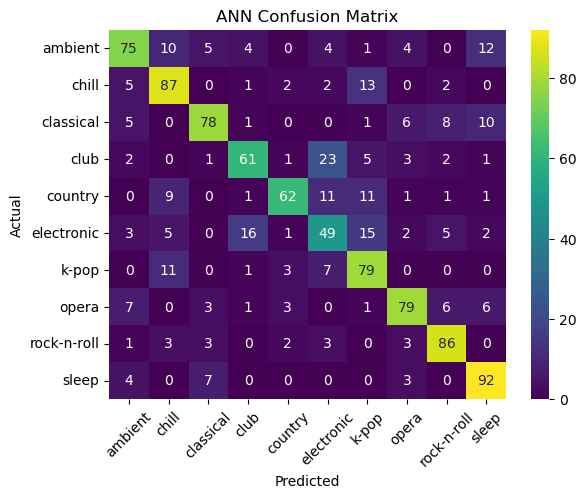

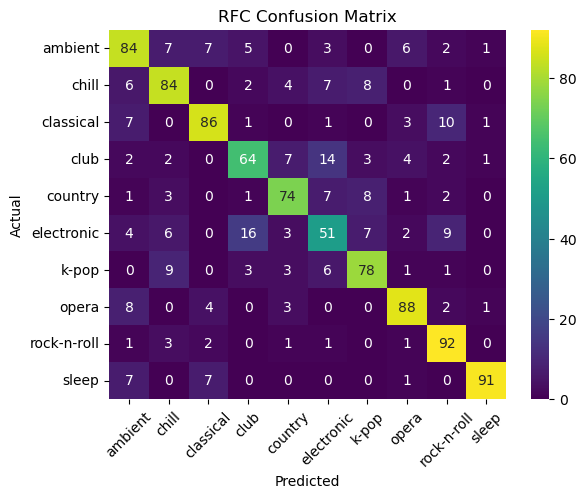

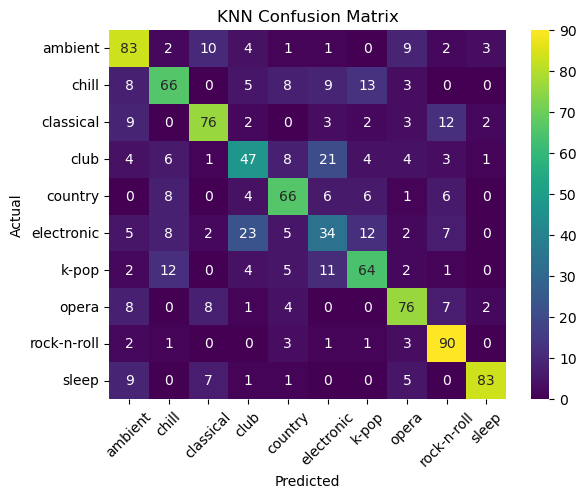

In [114]:
plot_cm(ann_cm, lbl, 'ANN Confusion Matrix')
plot_cm(rfc_cm, lbl, 'RFC Confusion Matrix')
plot_cm(knn_cm, lbl, 'KNN Confusion Matrix')

We also plot the accuracy, loss, F1, and precision-recall curve of the neural network model.

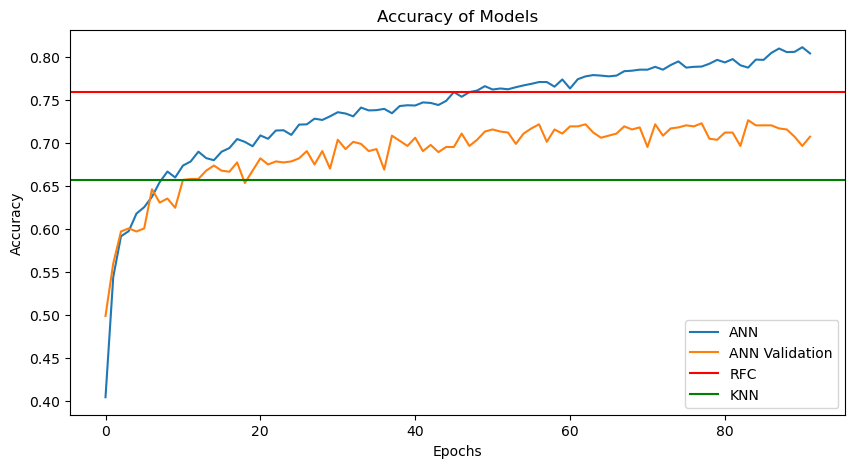

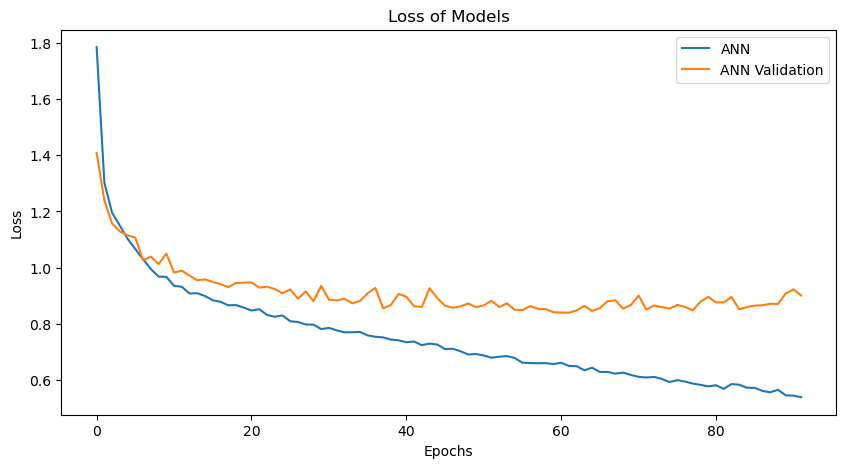

In [115]:
# Plot the accuracy of the models
plt.figure(figsize=(10, 5))
plt.plot(ann_history.history['accuracy'], label='ANN')
plt.plot(ann_history.history['val_accuracy'], label='ANN Validation')
plt.axhline(y=rfc_score, color='r', linestyle='-', label='RFC')
plt.axhline(y=knn_score, color='g', linestyle='-', label='KNN')
plt.title('Accuracy of Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss of the models
plt.figure(figsize=(10, 5))
plt.plot(ann_history.history['loss'], label='ANN')
plt.plot(ann_history.history['val_loss'], label='ANN Validation')
plt.title('Loss of Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can extract feature importance from Random Forest.

[Text(0.5, 1.0, 'Feature Importance of RFC'),
 Text(0.5, 0, 'Importance'),
 Text(0, 0.5, 'Features')]

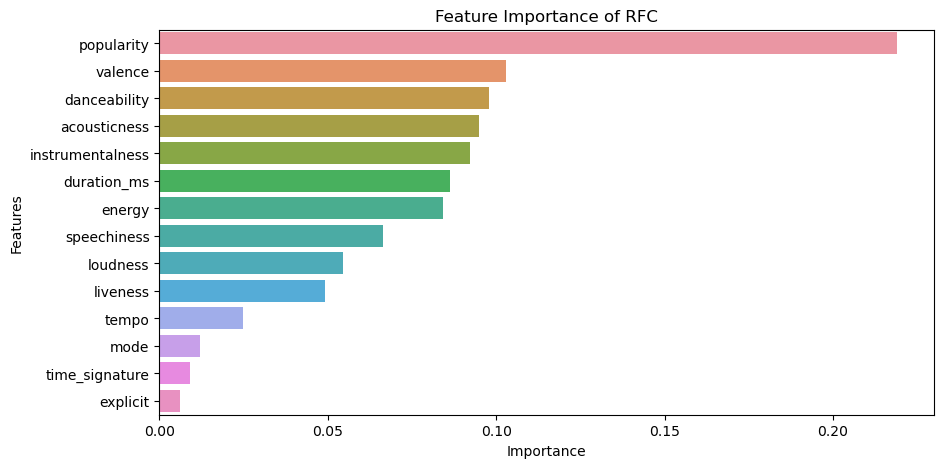

In [119]:
rfc_feature_importance = rfc_grid.best_estimator_.feature_importances_
rfc_feature_importance = pd.Series(rfc_feature_importance, index=X.columns)
rfc_feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
g = sns.barplot(x=rfc_feature_importance, y=rfc_feature_importance.index)
g.set(title='Feature Importance of RFC', xlabel='Importance', ylabel='Features')